In [2]:
import geopandas
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.lines as mlines
import numpy
import pulp
from pulp import GLPK
import shapely
import spopt
from spopt.locate import MCLP, simulated_geo_points
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
# ignore deprecation warning - GH pysal/spaghetti#649
import spaghetti


/Users/kd6801/opt/anaconda3/lib/python3.9/site-packages/spaghetti/network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [3]:
import geopandas as gpd
import pandas as pd
from sklearn.cluster import DBSCAN
#import utm
#import hdbscan
import os
import contextily as ctx
import folium
import webbrowser
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans
import numpy as np

In [4]:
#!Pip install utm

In [5]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point  #

def summarize_clusters(gdf):
    """
    Summarizes the clusters in a GeoDataFrame that includes a 'cluster' label column derived from K-means clustering.
    It now also calculates the total 'raw_visit_counts' for each cluster as weights.

    Parameters:
    - gdf (gpd.GeoDataFrame): GeoDataFrame with 'latitude', 'longitude' for foot traffic points,
                              a 'cluster' column, and 'raw_visit_counts' indicating the volume of visits.
    
    Returns:
    - pd.DataFrame: DataFrame where each row represents a cluster with columns for the
                    number of points in the cluster, total visit counts, the cluster label, 
                    and the centroid geometry.
    """
    # Ensure the 'cluster' column exists
    if 'cluster' not in gdf.columns:
        raise ValueError("GeoDataFrame must include a 'cluster' column")

    # Group by cluster label
    grouped = gdf.groupby('cluster')

    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'num_points': grouped.size(),  # Count points per cluster
        'total_visit_counts': grouped['raw_visit_counts'].sum(),  # Sum of visit counts per cluster
        'centroid': grouped.apply(lambda x: Point(x['longitude'].mean(), x['latitude'].mean()))  # Calculate centroid of each cluster
    }).reset_index()

    # Rename columns appropriately
    summary_df.columns = ['cluster_label', 'num_points', 'total_visit_counts', 'geometry']

    # Convert centroids to GeoDataFrame
    summary_df = gpd.GeoDataFrame(
        summary_df, 
        geometry='geometry',
        crs='EPSG:4326'  # Set the coordinate reference system to WGS 84
    )

    return summary_df


## We need to first load the data

In [6]:
# Load API Data
api_data = pd.read_json('/Users/kd6801/Desktop/MiniData/Jersey-City/Jersey_City_NJ_Apartment_data.json')

# Load building foot-traffic data
path_to_NJ_parquet =  '/Users/kd6801/Desktop/MiniData/foot-traffic/jersey_city_full_patterns.parquet'
foot =  pd.read_parquet(path_to_NJ_parquet, engine='pyarrow')


large_apartments_NJ_path = '/Users/kd6801/Desktop/MiniData/large_apartments_Jersey_City.geojson'
large_apartments_NJ =  gpd.read_file(large_apartments_NJ_path)

small_apartment_NJ_path =  '/Users/kd6801/Desktop/MiniData/small_apartments_Jersey_City.geojson'
small_apartment_NJ =   gpd.read_file(small_apartment_NJ_path)


In [7]:
print(f"We have {len(large_apartments_NJ)} large apartment buildings and {len(small_apartment_NJ)} small apartment buildings in Jersey City")
print(f"We have {len(foot)} foot-traffic points in Jersey City")
foot.columns

We have 75 large apartment buildings and 565 small apartment buildings in Jersey City
We have 137807 foot-traffic points in Jersey City


Index(['placekey', 'safegraph_place_id', 'parent_placekey',
       'parent_safegraph_place_id', 'location_name', 'safegraph_brand_ids',
       'brands', 'top_category', 'sub_category', 'category_tags', 'naics_code',
       'latitude', 'longitude', 'street_address', 'city', 'region',
       'postal_code', 'iso_country_code', 'phone_number', 'open_hours',
       'opened_on', 'closed_on', 'tracking_opened_since',
       'tracking_closed_since', 'date_range_start', 'date_range_end',
       'raw_visit_counts', 'raw_visitor_counts', 'visits_by_day',
       'visitor_home_cbgs', 'visitor_country_of_origin', 'distance_from_home',
       'median_dwell', 'bucketed_dwell_times', 'related_same_day_brand',
       'related_same_month_brand', 'popularity_by_hour', 'popularity_by_day',
       'device_type', 'poi_cbg', 'visitor_daytime_cbgs'],
      dtype='object')

## I plan to use K-means method for clustering

In [88]:
from sklearn.cluster import KMeans
import numpy as np

# Convert DataFrame to GeoDataFrame
gdf_foot_traffic = gpd.GeoDataFrame(
    foot, 
    geometry=gpd.points_from_xy(foot.longitude, foot.latitude)
)
gdf_foot_traffic.set_crs(large_apartments_NJ.crs, inplace=True)



coords = gdf_foot_traffic[['latitude', 'longitude']]

# Check for NaN values and fill them
coords = coords.fillna(coords.mean())  # Filling NaNs with mean of each column

# Check for infinite values and handle them
coords.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinities with NaN
coords.fillna(coords.mean(), inplace=True)  # Fill new NaNs potentially created

# Running K-means
kmeans = KMeans(n_clusters=200)  
clusters = kmeans.fit_predict(coords.values)

# for certain size of a city, jersey city 15 square miles
# 1/4 square miles per cluster

# Assign clusters back to the GeoDataFrame
gdf_foot_traffic['cluster'] = clusters



## Alternative K-means

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Convert DataFrame to GeoDataFrame
gdf_foot_traffic = gpd.GeoDataFrame(
    foot, 
    geometry=gpd.points_from_xy(foot.longitude, foot.latitude)
)
gdf_foot_traffic.set_crs(large_apartments_NJ.crs, inplace=True)


coords = gdf_foot_traffic[['latitude', 'longitude']]
foot_traffic_counts = gdf_foot_traffic['raw_visit_counts'].values

# Check for NaN values and fill them
coords = coords.fillna(coords.mean())  # Filling NaNs with mean of each column

# # Check for infinite values and handle them
# coords.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinities with NaN
# coords.fillna(coords.mean(), inplace=True)  # Fill new NaNs potentially created

# # Running K-means
# kmeans = KMeans(n_clusters=200)  
# clusters = kmeans.fit_predict(coords.values)

# # for certain size of a city, jersey city 15 square miles
# # 1/4 square miles per cluster

# # Assign clusters back to the GeoDataFrame
# gdf_foot_traffic['cluster'] = clusters



# Define number of clusters (demand points)
n_clusters = 1000  

# Perform K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(coords)

# Get cluster centroids and weights
cluster_centroids = kmeans.cluster_centers_
cluster_weights = np.bincount(kmeans.labels_, weights=foot_traffic_counts)




In [9]:
gdf_foot_traffic['cluster'].value_counts()
gdf_foot_traffic.columns

Index(['placekey', 'safegraph_place_id', 'parent_placekey',
       'parent_safegraph_place_id', 'location_name', 'safegraph_brand_ids',
       'brands', 'top_category', 'sub_category', 'category_tags', 'naics_code',
       'latitude', 'longitude', 'street_address', 'city', 'region',
       'postal_code', 'iso_country_code', 'phone_number', 'open_hours',
       'opened_on', 'closed_on', 'tracking_opened_since',
       'tracking_closed_since', 'date_range_start', 'date_range_end',
       'raw_visit_counts', 'raw_visitor_counts', 'visits_by_day',
       'visitor_home_cbgs', 'visitor_country_of_origin', 'distance_from_home',
       'median_dwell', 'bucketed_dwell_times', 'related_same_day_brand',
       'related_same_month_brand', 'popularity_by_hour', 'popularity_by_day',
       'device_type', 'poi_cbg', 'visitor_daytime_cbgs', 'geometry',
       'cluster'],
      dtype='object')

In [89]:
cluster_summary = summarize_clusters(gdf_foot_traffic)
cluster_summary.head(100)
#cluster_summary.columns

,cluster_label,num_points,total_visit_counts,geometry
0,0,2223,731885.0,POINT (-74.06460 40.73046)
1,1,820,81381.0,POINT (-74.04299 40.71678)
2,2,544,71417.0,POINT (-74.09527 40.69984)
3,3,752,65243.0,POINT (-74.04593 40.74164)
4,4,900,219248.0,POINT (-74.07863 40.71910)
...,...,...,...,...
95,95,415,77842.0,POINT (-74.09525 40.71563)
96,96,856,86453.0,POINT (-74.05127 40.72396)
97,97,613,128152.0,POINT (-74.09818 40.69603)
98,98,2647,206834.0,POINT (-74.04355 40.71993)


In [94]:
cluster_summary['weights'] = cluster_summary['total_visit_counts']/100000
cluster_summary

,cluster_label,num_points,total_visit_counts,geometry,weights
0,0,2223,731885.0,POINT (-74.06460 40.73046),7.31885
1,1,820,81381.0,POINT (-74.04299 40.71678),0.81381
2,2,544,71417.0,POINT (-74.09527 40.69984),0.71417
3,3,752,65243.0,POINT (-74.04593 40.74164),0.65243
4,4,900,219248.0,POINT (-74.07863 40.71910),2.19248
...,...,...,...,...,...
195,195,1850,96582.0,POINT (-74.04389 40.71827),0.96582
196,196,100,23279.0,POINT (-74.06150 40.69930),0.23279
197,197,582,208206.0,POINT (-74.03819 40.73245),2.08206
198,198,782,156591.0,POINT (-74.06174 40.73026),1.56591


In [12]:
%matplotlib inline


In [13]:

# previously set it to 60
CLIENT_COUNT = 200

# quantity supply points (Given)
FACILITY_COUNT = 125

# maximum service radius (in distance units) we can use grid search method to fidn the optimal service radius
SERVICE_RADIUS = 50

# number of candidate facilities in optimal solution (We simply halved athe FACILITY_COUNT)
P_FACILITIES = 60

# random seeds for reproducibility
CLIENT_SEED = 222
FACILITY_SEED = 333

# set the solver
#solver = pulp.COIN_CMD(msg=False, warmStart=True)
# set the solver
#solver = GLPK(msg=True)

In [14]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point

# Assuming data loading paths are set correctly
# large_apartments_NJ = gpd.read_file("path_to_large_apartments_data.geojson")
# clustered_gdf = gpd.read_file("path_to_clustered_data.geojson")

def clean_coordinates(gdf):
    """ Ensure all geometries are valid and finite """
    # Remove any rows with None or NaN geometries
    gdf = gdf[gdf['geometry'].notna()]
    # Ensure all coordinates are finite
    gdf = gdf[gdf['geometry'].apply(lambda geom: np.isfinite(geom.x) and np.isfinite(geom.y))]
    return gdf

# Clean the data
client_points = clean_coordinates(cluster_summary[['geometry', 'weights']])
facility_points = clean_coordinates(large_apartments_NJ.head(75)[['geometry']])

# Find the index of the point with the largest latitude
index_of_max_lat = client_points.geometry.y.idxmax()

# Drop the point
client_points = client_points.drop(index_of_max_lat)

# Continue with previous steps...


In [15]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from spopt.locate import MCLP
from scipy.spatial import cKDTree
import warnings
from pulp import PULP_CBC_CMD


# `large_apartments_NJ` and `clustered_gdf` are pre-loaded GeoDataFrames containing your supply and demand points respectively


# def calculate_cost_matrix(demand_gdf, supply_gdf, radius):
#     demand_coords = np.array(list(demand_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
#     supply_coords = np.array(list(supply_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    
#     # Create a tree from the supply coordinates
#     tree = cKDTree(supply_coords)
#     # Query this tree for distances less than radius to demand points
#     demand_indices = np.arange(len(demand_coords))
#     supply_indices = tree.query_ball_point(demand_coords, r=radius)
    
#     # Create a boolean cost matrix
#     cost_matrix = np.zeros((len(demand_indices), len(supply_coords)), dtype=bool)
#     for demand_idx, nearby_supply_indices in zip(demand_indices, supply_indices):
#         cost_matrix[demand_idx, nearby_supply_indices] = True
    
#     return cost_matrix

def calculate_cost_matrix(demand_gdf, supply_gdf, radius):
    demand_coords = np.array(list(demand_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    supply_coords = np.array(list(supply_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    
    tree = cKDTree(supply_coords)
    demand_indices = np.arange(len(demand_coords))
    supply_indices = [tree.query_ball_point(point, r=radius) for point in demand_coords]
    
    cost_matrix = np.zeros((len(demand_indices), len(supply_coords)), dtype=bool)
    for demand_idx, nearby_supply_indices in zip(demand_indices, supply_indices):
        cost_matrix[demand_idx, nearby_supply_indices] = True
    
    return cost_matrix

# Get weights and cost matrix
weights = client_points['weights'].values
cost_matrix = calculate_cost_matrix(client_points, facility_points, SERVICE_RADIUS)



# Setting up MCLP
mclp = MCLP.from_cost_matrix(cost_matrix, weights, SERVICE_RADIUS, P_FACILITIES)

solver = PULP_CBC_CMD()
mclp.solve(solver)


# Solving the MCLP
#mclp.solve(pulp.PULP_CBC_CMD(msg=False))  # Using CBC solver

# if hasattr(mclp, 'facility_client_array'):
#     # This block executes if the 'facility_client_array' attribute exists
#     facility_points['selected'] = mclp.facility_client_array.sum(axis=0) > 0
#     coverage = mclp.facility_client_array.sum() / weights.sum() * 100
#     print(f"{coverage}% coverage is observed")
# else:
#     print("Check MCLP model setup and solution: Expected attributes not found.")


# Results
# facility_points['selected'] = mclp.facility_client_array.sum(axis=0) > 0  # Boolean flag for selected facilities
# coverage = mclp.facility_client_array.sum() / weights.sum() * 100  # Calculate coverage percentage

print(f"{mclp.perc_cov}% coverage is observed")





Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/kd6801/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/84b33b4cb2ea437086e6f031567abf9a-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/84b33b4cb2ea437086e6f031567abf9a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 205 COLUMNS
At line 16150 RHS
At line 16351 BOUNDS
At line 16626 ENDATA
Problem MODEL has 200 rows, 274 columns and 15199 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 225.838 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -225.838 to -1.79769e+308
Probing was tried 0 times and cr

In [16]:
facility_points.columns

Index(['geometry'], dtype='object')

In [17]:
import osmnx as ox
import geopandas as gpd
import spaghetti
import matplotlib.pyplot as plt
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Specify the location and download the road network
    place_name = "Jersey City, New Jersey, USA"
    graph = ox.graph_from_place(place_name, network_type='drive')

    # Convert to spaghetti Network structure
    ntw = spaghetti.Network(in_data=ox.graph_to_gdfs(graph, nodes=False, edges=True))

    # Convert the network edges to a GeoDataFrame
    streets = spaghetti.element_as_gdf(ntw, arcs=True)

    # Buffer the streets and create a unified buffer (union of all buffers)
    streets_buffered = gpd.GeoDataFrame(
        gpd.GeoSeries(streets["geometry"].buffer(0.5).unary_union),
        crs=streets.crs,
        columns=["geometry"]
    )




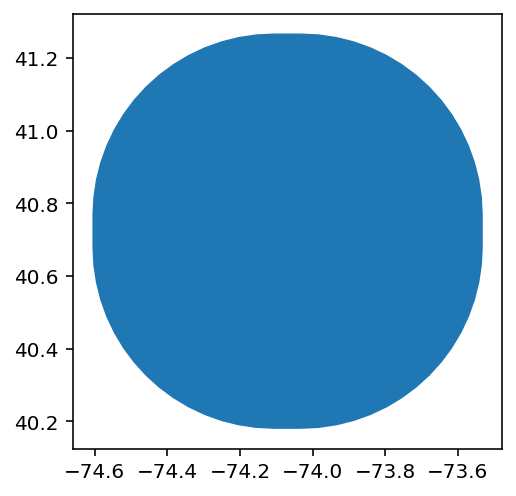

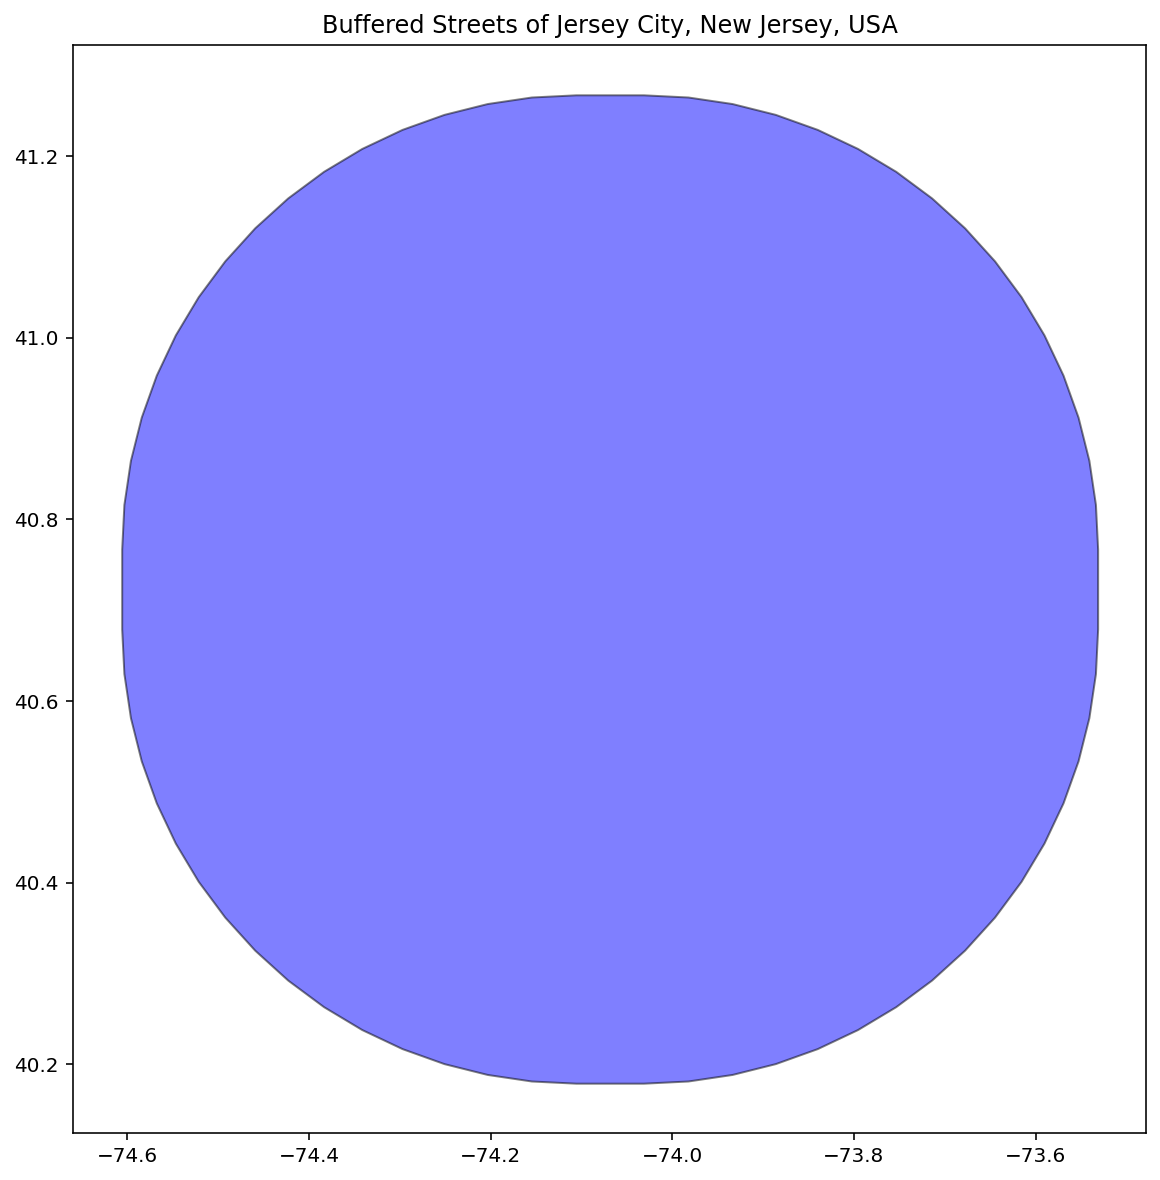

In [43]:
streets_buffered.plot()

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
streets_buffered.plot(ax=ax, alpha=0.5, color='blue', edgecolor='black')
ax.set_title("Buffered Streets of " + place_name)
plt.show()

#put the base map in the background

In [19]:
client_points

,geometry,weights
0,POINT (-74.06018 40.73471),0.92551
1,POINT (-74.09119 40.69533),0.81301
2,POINT (-74.04364 40.71908),1.01996
3,POINT (-74.08353 40.71856),1.22269
4,POINT (-74.04805 40.74750),1.25660
...,...,...
195,POINT (-74.09929 40.70000),0.56581
196,POINT (-74.05112 40.74313),1.36082
197,POINT (-74.09210 40.69135),0.34346
198,POINT (-74.04429 40.71742),0.79416


In [20]:
# y_max = client_points.geometry.y.idxmax()
# y_min=  client_points.geometry.y.idxmin()
# x_max= client_points.geometry.x.idxmax()
# x_min=  client_points.geometry.x.idxmin()

# print(y_max)
# print(y_min)
# print(x_max)
# print(x_min)

# #client_points.iloc[51]
# client_points.iloc[40]
# #client_points.iloc[119]


# #client_points.iloc[68]

min, ymin, xmax, ymax = client_points.total_bounds

Centroid: POINT (-74.06384887390332 40.72290876558516)


/var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/ipykernel_90291/2490631718.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  max_distance = client_points.geometry.distance(centroid).max()


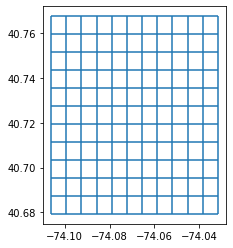

In [21]:
# Calculate the centroid of all points
centroid = client_points.geometry.unary_union.centroid
print("Centroid:", centroid)

# Define the extent of the lattice based on the maximum distance to the centroid
max_distance = client_points.geometry.distance(centroid).max()
#minx, miny, maxx, maxy = centroid.x - max_distance, centroid.y - max_distance, centroid.x + max_distance, centroid.y + max_distance
minx, miny, maxx, maxy = client_points.total_bounds

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Create network with regular lattice centered around centroid
    lattice = spaghetti.regular_lattice((minx, miny, maxx, maxy), 10, exterior=True)
ntw = spaghetti.Network(in_data=lattice)


streets = spaghetti.element_as_gdf(ntw, arcs=True)

streets_buffered = geopandas.GeoDataFrame(
    geopandas.GeoSeries(streets["geometry"].buffer(0.5).unary_union),
    crs=streets.crs,
    columns=["geometry"],
)

streets.plot();

In [23]:
# from shapely import wkt

# #client_points['geometry'] = client_points['geometry'].apply(wkt.loads)
# gdf_points = gpd.GeoDataFrame(client_points, geometry='geometry', crs="EPSG:4326")

# # Create network
# lattice = spaghetti.regular_lattice((-74.093269, 40.678916, -74.02984148, 40.744577), 3, exterior=True)
# ntw = spaghetti.Network(in_data=lattice)

# # Convert network arcs to GeoDataFrame
# streets = spaghetti.element_as_gdf(ntw, arcs=True)

# # Buffer the streets and create a union of the buffered areas
# streets_buffered = gpd.GeoDataFrame(
#     gpd.GeoSeries(streets["geometry"].buffer(0.005).unary_union),
#     crs=streets.crs,
#     columns=["geometry"],
# )

# # Plotting
# fig, ax = plt.subplots(figsize=(10, 10))
# streets_buffered.plot(ax=ax, color="blue", alpha=0.5)
# gdf_points.plot(ax=ax, color="red", markersize=5)
# plt.show()

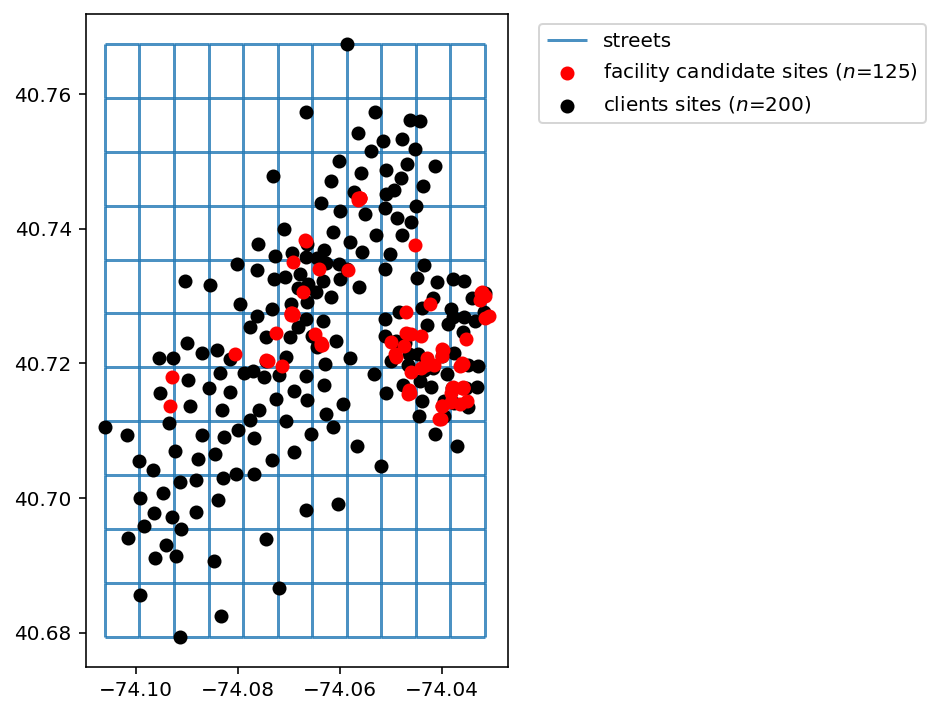

In [65]:

fig, ax = plt.subplots(figsize=(6, 6))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
facility_points.plot(
    ax=ax, color="red", zorder=2, label=f"facility candidate sites ($n$={FACILITY_COUNT})"
)
client_points.plot(ax=ax, color="black", label=f"clients sites ($n$={CLIENT_COUNT})")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

In [66]:
print(streets_buffered.crs)
print(facility_points.crs)
print(client_points.crs)

print(streets.total_bounds)
print(facility_points.total_bounds)
print(client_points.total_bounds)


# If they are different, decide on a common CRS and transform each GeoDataFrame to that CRS
common_crs = 'EPSG:4326'  # For example, using EPSG:4326 for geographic coordinates
facility_points = facility_points.to_crs(common_crs)
client_points = client_points.to_crs(common_crs)


None
epsg:4326
EPSG:4326
[-74.10608284  40.67934814 -74.03167512  40.76744033]
[-74.093269  40.711723 -74.030831  40.744577]
[-74.10608284  40.67934814 -74.03167512  40.76744033]


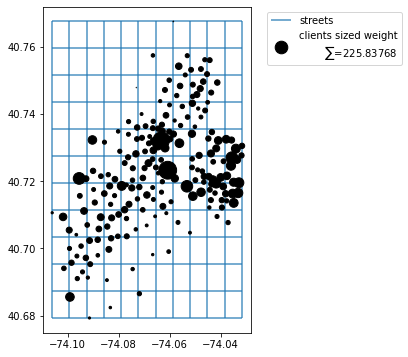

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
client_points.plot(
    ax=ax,
    color="black",
    label=f"clients sized weight\n\t$\\sum$={client_points['weights'].sum()}",
    markersize=client_points["weights"]*30
)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

In [27]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/libpysal#468
    ntw.snapobservations(client_points, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(ntw, pp_name="clients", snapped=True)
clients_snapped.drop(columns=["id", "comp_label"], inplace=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/libpysal#468
    ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(ntw, pp_name="facilities", snapped=True)
facilities_snapped.drop(columns=["id", "comp_label"], inplace=True)

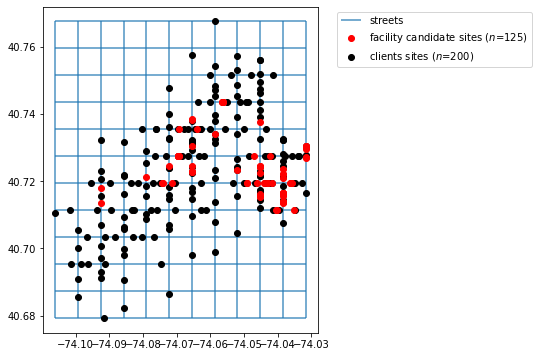

In [29]:
fig, ax = plt.subplots(figsize=(6, 6))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
facilities_snapped.plot(
    ax=ax, color="red", zorder=2, label=f"facility candidate sites ($n$={FACILITY_COUNT})"
)
clients_snapped.plot(ax=ax, color="black", label=f"clients sites ($n$={CLIENT_COUNT})")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

In [30]:
# cost_matrix = ntw.allneighbordistances(
#     sourcepattern=ntw.pointpatterns["clients"],
#     destpattern=ntw.pointpatterns["facilities"],
# )
# cost_matrix.shape



In [45]:
clients_snapped
# We will be using this as client coordinates

,geometry,weights
0,POINT (-74.06018 40.73541),0.92551
1,POINT (-74.09119 40.69536),0.81301
2,POINT (-74.04364 40.71939),1.01996
3,POINT (-74.08353 40.71939),1.22269
4,POINT (-74.04520 40.74750),1.25660
...,...,...
194,POINT (-74.09932 40.70000),0.57950
195,POINT (-74.05112 40.74342),0.56581
196,POINT (-74.09255 40.69135),1.36082
197,POINT (-74.04520 40.71742),0.34346


In [44]:
facility_points

,geometry,dv
0,POINT (-74.04313 40.71972),y0
1,POINT (-74.06409 40.73405),y1
2,POINT (-74.03509 40.71437),y2
3,POINT (-74.06720 40.73055),y3
4,POINT (-74.03815 40.71635),y4
...,...,...
70,POINT (-74.06694 40.73839),y70
71,POINT (-74.06660 40.73820),y71
72,POINT (-74.03828 40.71422),y72
73,POINT (-74.04715 40.72760),y73


In [49]:
# We use the Mapbox API to calculate the cost matrix

import requests
import numpy as np
import itertools
from pulp import PULP_CBC_CMD

MAPBOX_ACCESS_TOKEN = 'pk.eyJ1Ijoia2V2aW4yMzM1IiwiYSI6ImNsdTFvemlkbjBpYTYyaWw4M3htaHdudHoifQ.TYgwwXuY0hFdfVV-NnMtwA'
MAX_COORDS = 25

# Create a copy
demand_points = client_points
potential_bin_locations = facility_points

# previously set it to 60
CLIENT_COUNT = 200

# quantity supply points (Given)
FACILITY_COUNT = 125

# maximum service radius (in distance units) we can use grid search method to fidn the optimal service radius
SERVICE_RADIUS = 50

# number of candidate facilities in optimal solution (We simply halved athe FACILITY_COUNT)
P_FACILITIES = 60

# random seeds for reproducibility
CLIENT_SEED = 222
FACILITY_SEED = 333

# Extract the demand coordiantes and weights

demand_coords = [(point.x, point.y) for point in demand_points.geometry]
weight_array = np.array(client_points["weights"])

# Extract the facility coordinates 

facility_coords = [(point.x, point.y) for point in potential_bin_locations.geometry]




In [53]:
def chunk_coordinates(coords, chunk_size):
    for i in range(0, len(coords), chunk_size):
        yield coords[i:i + chunk_size]

def get_cost_matrix(client_chunk, facility_chunk):
    all_coords = client_chunk + facility_chunk
    coord_str = ';'.join([f"{lon},{lat}" for lon, lat in all_coords])
    url = f"https://api.mapbox.com/directions-matrix/v1/mapbox/driving/{coord_str}?annotations=duration&access_token={MAPBOX_ACCESS_TOKEN}"
    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Error: Received status code {response.status_code} from Mapbox API")
        print(response.text)
        return np.full((len(client_chunk), len(facility_chunk)), np.inf)

    matrix_data = response.json()
    if 'durations' not in matrix_data:
        print("Error: 'durations' key not found in response")
        print(matrix_data)
        return np.full((len(client_chunk), len(facility_chunk)), np.inf)
    
    return np.array(matrix_data['durations'])

client_chunks = list(chunk_coordinates(demand_coords, MAX_COORDS // 2))
facility_chunks = list(chunk_coordinates(facility_coords, MAX_COORDS // 2))

cost_matrix = np.full((len(demand_points), len(potential_bin_locations)), np.inf)

for i, client_chunk in enumerate(client_chunks):
    for j, facility_chunk in enumerate(facility_chunks):
        chunk_cost_matrix = get_cost_matrix(client_chunk, facility_chunk)
        num_clients = len(client_chunk)
        num_facilities = len(facility_chunk)
        start_client_idx = i * (MAX_COORDS // 2)
        start_facility_idx = j * (MAX_COORDS // 2)
        cost_matrix[start_client_idx:start_client_idx + num_clients, start_facility_idx:start_facility_idx + num_facilities] = chunk_cost_matrix[:num_clients, num_clients:num_clients + num_facilities]


In [58]:
cost_matrix.shape

(199, 75)

In [60]:
cost_matrix

array([[ 674.8,  174.9,  990.2, ...,  919.4,  467.7,  931.6],
       [ 896.6, 1095.3, 1083.3, ..., 1001.3,  807. , 1065.1],
       [  76.6,  705. ,  380.7, ...,  313.8,  432.6,  326. ],
       ...,
       [ 920.7, 1194.6, 1107.4, ..., 1025.4,  831.1, 1089.2],
       [ 126.2,  736.6,  298.3, ...,  243.6,  464.2,  255.8],
       [ 699.9,  423.6, 1015.3, ...,  944.5,  492.8,  956.7]])

In [84]:
from spopt.locate.coverage import MCLP
# Perform grid search on SERVICE_RADIUS
service_radii = range(1, 500, 50)  # Adjust the range and step size as needed
coverage_results = []

for SERVICE_RADIUS in service_radii:
    mclp_from_cm = MCLP.from_cost_matrix(
        cost_matrix,
        weight_array,
        SERVICE_RADIUS,
        p_facilities=P_FACILITIES,
        name="mclp-network-distance"
    )
    # Solve the MCLP
    solver = PULP_CBC_CMD()
    mclp_from_cm = mclp_from_cm.solve(solver)

    # Store the coverage result
    coverage_results.append((SERVICE_RADIUS, mclp_from_cm.perc_cov))

# Print the coverage rates for each SERVICE_RADIUS
for SERVICE_RADIUS, coverage in coverage_results:
    print(f"Service Radius: {SERVICE_RADIUS} units, Coverage: {coverage}%")



Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/kd6801/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/84ad04c6aff443a39a87eea58ace9ded-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/84ad04c6aff443a39a87eea58ace9ded-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 205 COLUMNS
At line 1226 RHS
At line 1427 BOUNDS
At line 1702 ENDATA
Problem MODEL has 200 rows, 274 columns and 275 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.60308 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -0.60308 to -1.79769e+308
Probing was tried 0 times and created

## Basemap

In [71]:
# Visualize the results on a map for the best SERVICE_RADIUS
best_service_radius, best_coverage = max(coverage_results, key=lambda x: x[1])

mclp_from_cm = MCLP.from_cost_matrix(
    cost_matrix,
    weight_array,
    best_service_radius,
    p_facilities=P_FACILITIES,
    name="mclp-network-distance"
)

mclp_from_cm = mclp_from_cm.solve(solver)

m = folium.Map(location=[40.728157, -74.044500], zoom_start=13)

# Add demand points
for (lon, lat), weight in zip(demand_coords, weight_array):
    folium.Marker([lat, lon], popup=f'Demand Point (weight: {weight})', icon=folium.Icon(color='blue')).add_to(m)

# Add facility points
for i, (lon, lat) in enumerate(facility_coords):
    if mclp_from_cm.fac_vars[i].varValue == 1:
        folium.Marker([lat, lon], popup=f'Facility Location {i}', icon=folium.Icon(color='red')).add_to(m)

# Save the map to an HTML file
m.save('jersey_city_bins_map.html')

print(f"Best Service Radius: {best_service_radius} units, Coverage: {best_coverage}%")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/kd6801/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/58c8e46a326a4d00bf152046f3d958c7-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/58c8e46a326a4d00bf152046f3d958c7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 205 COLUMNS
At line 4111 RHS
At line 4312 BOUNDS
At line 4587 ENDATA
Problem MODEL has 200 rows, 274 columns and 3160 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 212.268 - 0.00 seconds
Cgl0004I processed model has 175 rows, 238 columns (238 integer (230 of which binary)) and 2616 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -212.268
Cbc0038I Cleaned solution of -212.268
Cbc0038I

## Enhanced map

In [100]:
# After solving the MCLP

# https://pysal.org/spopt/generated/spopt.locate.PMedian.html

# Determine which demand points are covered
covered_demand_indices = set()
for facility_clients in mclp_from_cm.fac2cli:
    for cli_idx in facility_clients:
        if cli_idx != -1:  # Check if the client index is valid
            covered_demand_indices.add(cli_idx)

# Create a map centered on Jersey City
m = folium.Map(location=[40.728157, -74.044500], zoom_start=13)

# Add covered and uncovered demand points with different colors
for idx, ((lon, lat), weight) in enumerate(zip(demand_coords, weight_array)):
    if idx in covered_demand_indices:
        folium.Marker([lat, lon], popup=f'Covered Demand Point (weight: {weight})', icon=folium.Icon(color='green')).add_to(m)
    else:
        folium.Marker([lat, lon], popup=f'Uncovered Demand Point (weight: {weight})', icon=folium.Icon(color='blue')).add_to(m)

# Add facility points
for i, (lon, lat) in enumerate(facility_coords):
    if mclp_from_cm.fac_vars[i].varValue == 1:
        folium.Marker([lat, lon], popup=f'Facility Location {i}', icon=folium.Icon(color='red')).add_to(m)


# Add a legend to the map
legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 200px; height: 150px; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color:white; opacity: 0.85;">
     &nbsp; <i class="fa fa-map-marker fa-2x" style="color:green"></i>&nbsp; Covered Demand Point<br>
     &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"></i>&nbsp; Uncovered Demand Point<br>
     &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"></i>&nbsp; Facility Location
     </div>
     '''

m.get_root().html.add_child(folium.Element(legend_html))

# Save the map to an HTML file
m.save('jersey_city_bins_map.html')

print(f"Best Service Radius: {best_service_radius} units, Coverage: {best_coverage}%")


Best Service Radius: 451 units, Coverage: 87.43718592964824%


In [63]:
import watermark
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-05-16T15:29:10.568454-05:00

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.2.0

Compiler    : Clang 12.0.0 
OS          : Darwin
Release     : 23.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [64]:
facility_points["dv"] = mclp_from_cm.fac_vars
facility_points["dv"] = facility_points["dv"].map(
    lambda x: x.name.replace("_", "").replace("x", "y")
)
facilities_snapped["dv"] = facility_points["dv"]
facility_points

,geometry,dv
0,POINT (-74.04313 40.71972),y0
1,POINT (-74.06409 40.73405),y1
2,POINT (-74.03509 40.71437),y2
3,POINT (-74.06720 40.73055),y3
4,POINT (-74.03815 40.71635),y4
...,...,...
70,POINT (-74.06694 40.73839),y70
71,POINT (-74.06660 40.73820),y71
72,POINT (-74.03828 40.71422),y72
73,POINT (-74.04715 40.72760),y73


In [39]:
distance_metric = "euclidean"
clients_snapped["weights"] = client_points["weights"]
mclp_from_gdf = MCLP.from_geodataframe(
    clients_snapped,
    facilities_snapped,
    "geometry",
    "geometry",
    "weights",
    SERVICE_RADIUS,
    p_facilities=P_FACILITIES,
    distance_metric=distance_metric,
    name=f"mclp-{distance_metric}-distance"
)

In [72]:
# mclp_from_gdf = mclp_from_gdf.solve(solver)
# print(f"{mclp_from_gdf.perc_cov}% coverage is observed")

In [ ]:
facility_points["predefined_loc"] = 0
facility_points.loc[(0, 1, 3), "predefined_loc"] = 1
facilities_snapped["predefined_loc"] = facility_points["predefined_loc"]
facility_points

,geometry,dv,predefined_loc
0,POINT (-74.04313 40.71972),y0,1
1,POINT (-74.06409 40.73405),y1,1
2,POINT (-74.03509 40.71437),y2,0
3,POINT (-74.06720 40.73055),y3,1
4,POINT (-74.03815 40.71635),y4,0
...,...,...,...
70,POINT (-74.06694 40.73839),y70,0
71,POINT (-74.06660 40.73820),y71,0
72,POINT (-74.03828 40.71422),y72,0
73,POINT (-74.04715 40.72760),y73,0


In [ ]:
mclp_from_gdf_pre = MCLP.from_geodataframe(
    clients_snapped,
    facilities_snapped,
    "geometry",
    "geometry",
    "weights",
    SERVICE_RADIUS,
    p_facilities=P_FACILITIES,
    predefined_facility_col="predefined_loc",
    distance_metric=distance_metric,
    name=f"mclp-{distance_metric}-distance-predefined"
)

In [ ]:
# mclp_from_gdf_pre = mclp_from_gdf_pre.solve(solver)
# print(f"{mclp_from_gdf_pre.perc_cov}% coverage is observed")

In [ ]:
dv_colors_arr = [
    "darkcyan",
    "mediumseagreen",
    "saddlebrown",
    "darkslategray",
    "lightskyblue",
    "thistle",
    "lavender",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
    "darkorange",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
    "darkorange",
    "darkcyan",
    "mediumseagreen",
    "saddlebrown",
    "darkslategray",
    "lightskyblue",
    "thistle",
    "lavender",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
    "darkorange",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
    "darkorange",
    "darkcyan",
    "mediumseagreen",
    "saddlebrown",
    "darkslategray",
    "lightskyblue",
    "thistle",
    "lavender",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
    "darkorange",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
    "darkorange",
    "darkcyan",
    "mediumseagreen",
    "saddlebrown",
    "darkslategray",
    "lightskyblue",
    "thistle",
    "lavender",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
    "darkorange",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
    "darkorange",
    "darkcyan",
    "mediumseagreen",
    "saddlebrown",
    "darkslategray",
    "lightskyblue",
    "thistle",
    "lavender",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
    "darkorange",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
    "darkorange"

]
dv_colors = {f"y{i}": dv_colors_arr[i] for i in range(len(dv_colors_arr))}
dv_colors

{'y0': 'darkcyan',
 'y1': 'mediumseagreen',
 'y2': 'saddlebrown',
 'y3': 'darkslategray',
 'y4': 'lightskyblue',
 'y5': 'thistle',
 'y6': 'lavender',
 'y7': 'darkgoldenrod',
 'y8': 'peachpuff',
 'y9': 'coral',
 'y10': 'mediumvioletred',
 'y11': 'blueviolet',
 'y12': 'fuchsia',
 'y13': 'cyan',
 'y14': 'limegreen',
 'y15': 'mediumorchid',
 'y16': 'darkorange',
 'y17': 'peachpuff',
 'y18': 'coral',
 'y19': 'mediumvioletred',
 'y20': 'blueviolet',
 'y21': 'fuchsia',
 'y22': 'cyan',
 'y23': 'limegreen',
 'y24': 'mediumorchid',
 'y25': 'darkorange',
 'y26': 'darkcyan',
 'y27': 'mediumseagreen',
 'y28': 'saddlebrown',
 'y29': 'darkslategray',
 'y30': 'lightskyblue',
 'y31': 'thistle',
 'y32': 'lavender',
 'y33': 'darkgoldenrod',
 'y34': 'peachpuff',
 'y35': 'coral',
 'y36': 'mediumvioletred',
 'y37': 'blueviolet',
 'y38': 'fuchsia',
 'y39': 'cyan',
 'y40': 'limegreen',
 'y41': 'mediumorchid',
 'y42': 'darkorange',
 'y43': 'peachpuff',
 'y44': 'coral',
 'y45': 'mediumvioletred',
 'y46': 'bluev

In [ ]:
def plot_results(model, p, facs, clis=None, ax=None):
    """Visualize optimal solution sets and context."""
    if not ax:
        multi_plot = False
        fig, ax = plt.subplots(figsize=(6, 6))
        markersize, markersize_factor = 4, 4
    else:
        ax.axis("off")
        multi_plot = True
        markersize, markersize_factor = 2, 2
    ax.set_title(model.name, fontsize=15)

    # extract facility-client relationships for plotting (except for p-dispersion)
    plot_clis = isinstance(clis, geopandas.GeoDataFrame)
    if plot_clis:
        cli_points = {}
    fac_sites = {}
    for i, dv in enumerate(model.fac_vars):
        if dv.varValue:
            dv, predef = facs.loc[i, ["dv", "predefined_loc"]]
            fac_sites[dv] = [i, predef]
            if plot_clis:
                geom = clis.iloc[model.fac2cli[i]]["geometry"]
                cli_points[dv] = geom

    # study area and legend entries initialization
    streets.plot(ax=ax, alpha=1, color="black", zorder=1)
    legend_elements = [mlines.Line2D([], [], color="black", label="streets")]

    if plot_clis:
        # any clients that not asscociated with a facility
        if model.name.startswith("mclp"):
            c = "k"
            if hasattr(model, 'n_cli_uncov'):
                if model.n_cli_uncov:
                    idx = [i for i, v in enumerate(model.cli2fac) if len(v) == 0]
                    pnt_kws = dict(ax=ax, fc=c, ec=c, marker="s", markersize=7, zorder=2)
                    clis.iloc[idx].plot(**pnt_kws)
                _label = f"Demand sites not covered ($n$={model.n_cli_uncov})"
                _mkws = dict(marker="s", markerfacecolor=c, markeredgecolor=c, linewidth=0)
                legend_elements.append(mlines.Line2D([], [], ms=3, label=_label, **_mkws))

    # all candidate facilities
    facs.plot(ax=ax, fc="brown", marker="*", markersize=80, zorder=8)
    _label = f"Facility sites ($n$={len(model.fac_vars)})"
    _mkws = dict(marker="*", markerfacecolor="brown", markeredgecolor="brown")
    legend_elements.append(mlines.Line2D([], [], ms=7, lw=0, label=_label, **_mkws))

    # facility-(client) symbology and legend entries
    zorder = 4
    for fname, (fac, predef) in fac_sites.items():
        cset = dv_colors[fname]
        if plot_clis:
            # clients
            geoms = cli_points[fname]
            gdf = geopandas.GeoDataFrame(geoms)
            gdf.plot(ax=ax, zorder=zorder, ec="k", fc=cset, markersize=100 * markersize)
            _label = f"Demand sites covered by {fname}"
            _mkws = dict(markerfacecolor=cset, markeredgecolor="k", ms=markersize + 7)
            legend_elements.append(
                mlines.Line2D([], [], marker="o", lw=0, label=_label, **_mkws)
            )
        # facilities
        ec = "k"
        lw = 2
        predef_label = "predefined"
        if model.name.endswith(predef_label) and predef:
            ec = "r"
            lw = 3
            fname += f" ({predef_label})"
        facs.iloc[[fac]].plot(
            ax=ax, marker="*", markersize=1000, zorder=9, fc=cset, ec=ec, lw=lw
        )
        _mkws = dict(markerfacecolor=cset, markeredgecolor=ec, markeredgewidth=lw)
        legend_elements.append(
            mlines.Line2D([], [], marker="*", ms=20, lw=0, label=fname, **_mkws)
        )
        # increment zorder up and markersize down for stacked client symbology
        zorder += 1
        if plot_clis:
            markersize -= markersize_factor / p

    if not multi_plot:
        # legend
        kws = dict(loc="upper left", bbox_to_anchor=(1.05, 0.7))
        plt.legend(handles=legend_elements, **kws)

KeyError: "['predefined_loc'] not in index"

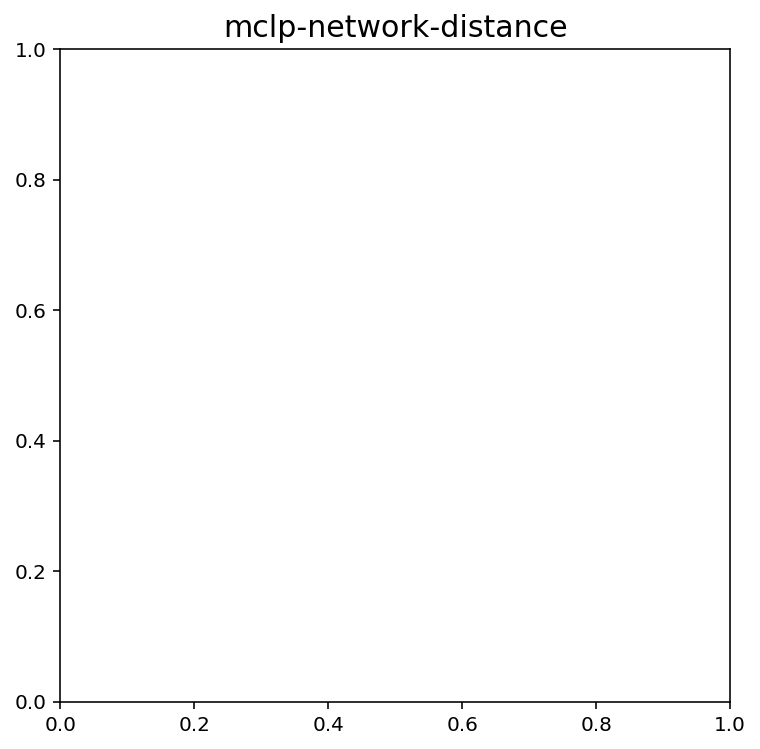

In [ ]:
plot_results(mclp_from_cm, P_FACILITIES, facility_points, clis=client_points)

AttributeError: 'MCLP' object has no attribute 'n_cli_uncov'

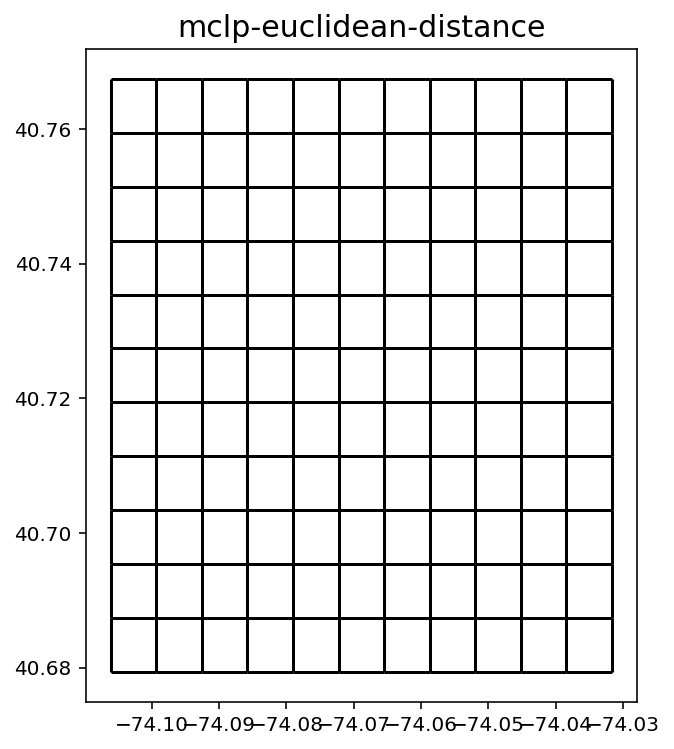

In [ ]:
plot_results(mclp_from_gdf, P_FACILITIES, facility_points, clis=client_points)

AttributeError: 'MCLP' object has no attribute 'fac2cli'

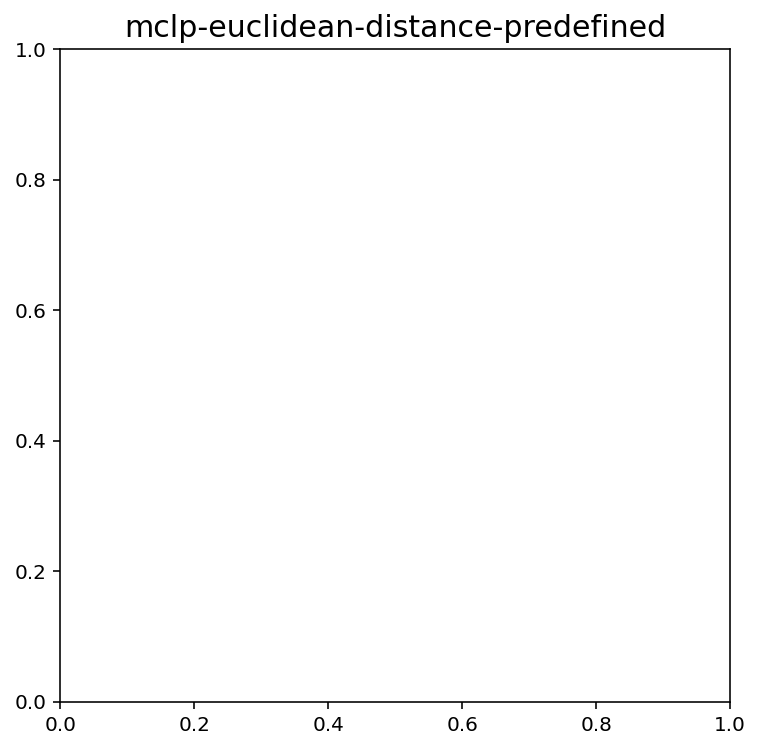

In [ ]:
plot_results(mclp_from_gdf_pre, P_FACILITIES, facility_points, clis=client_points)

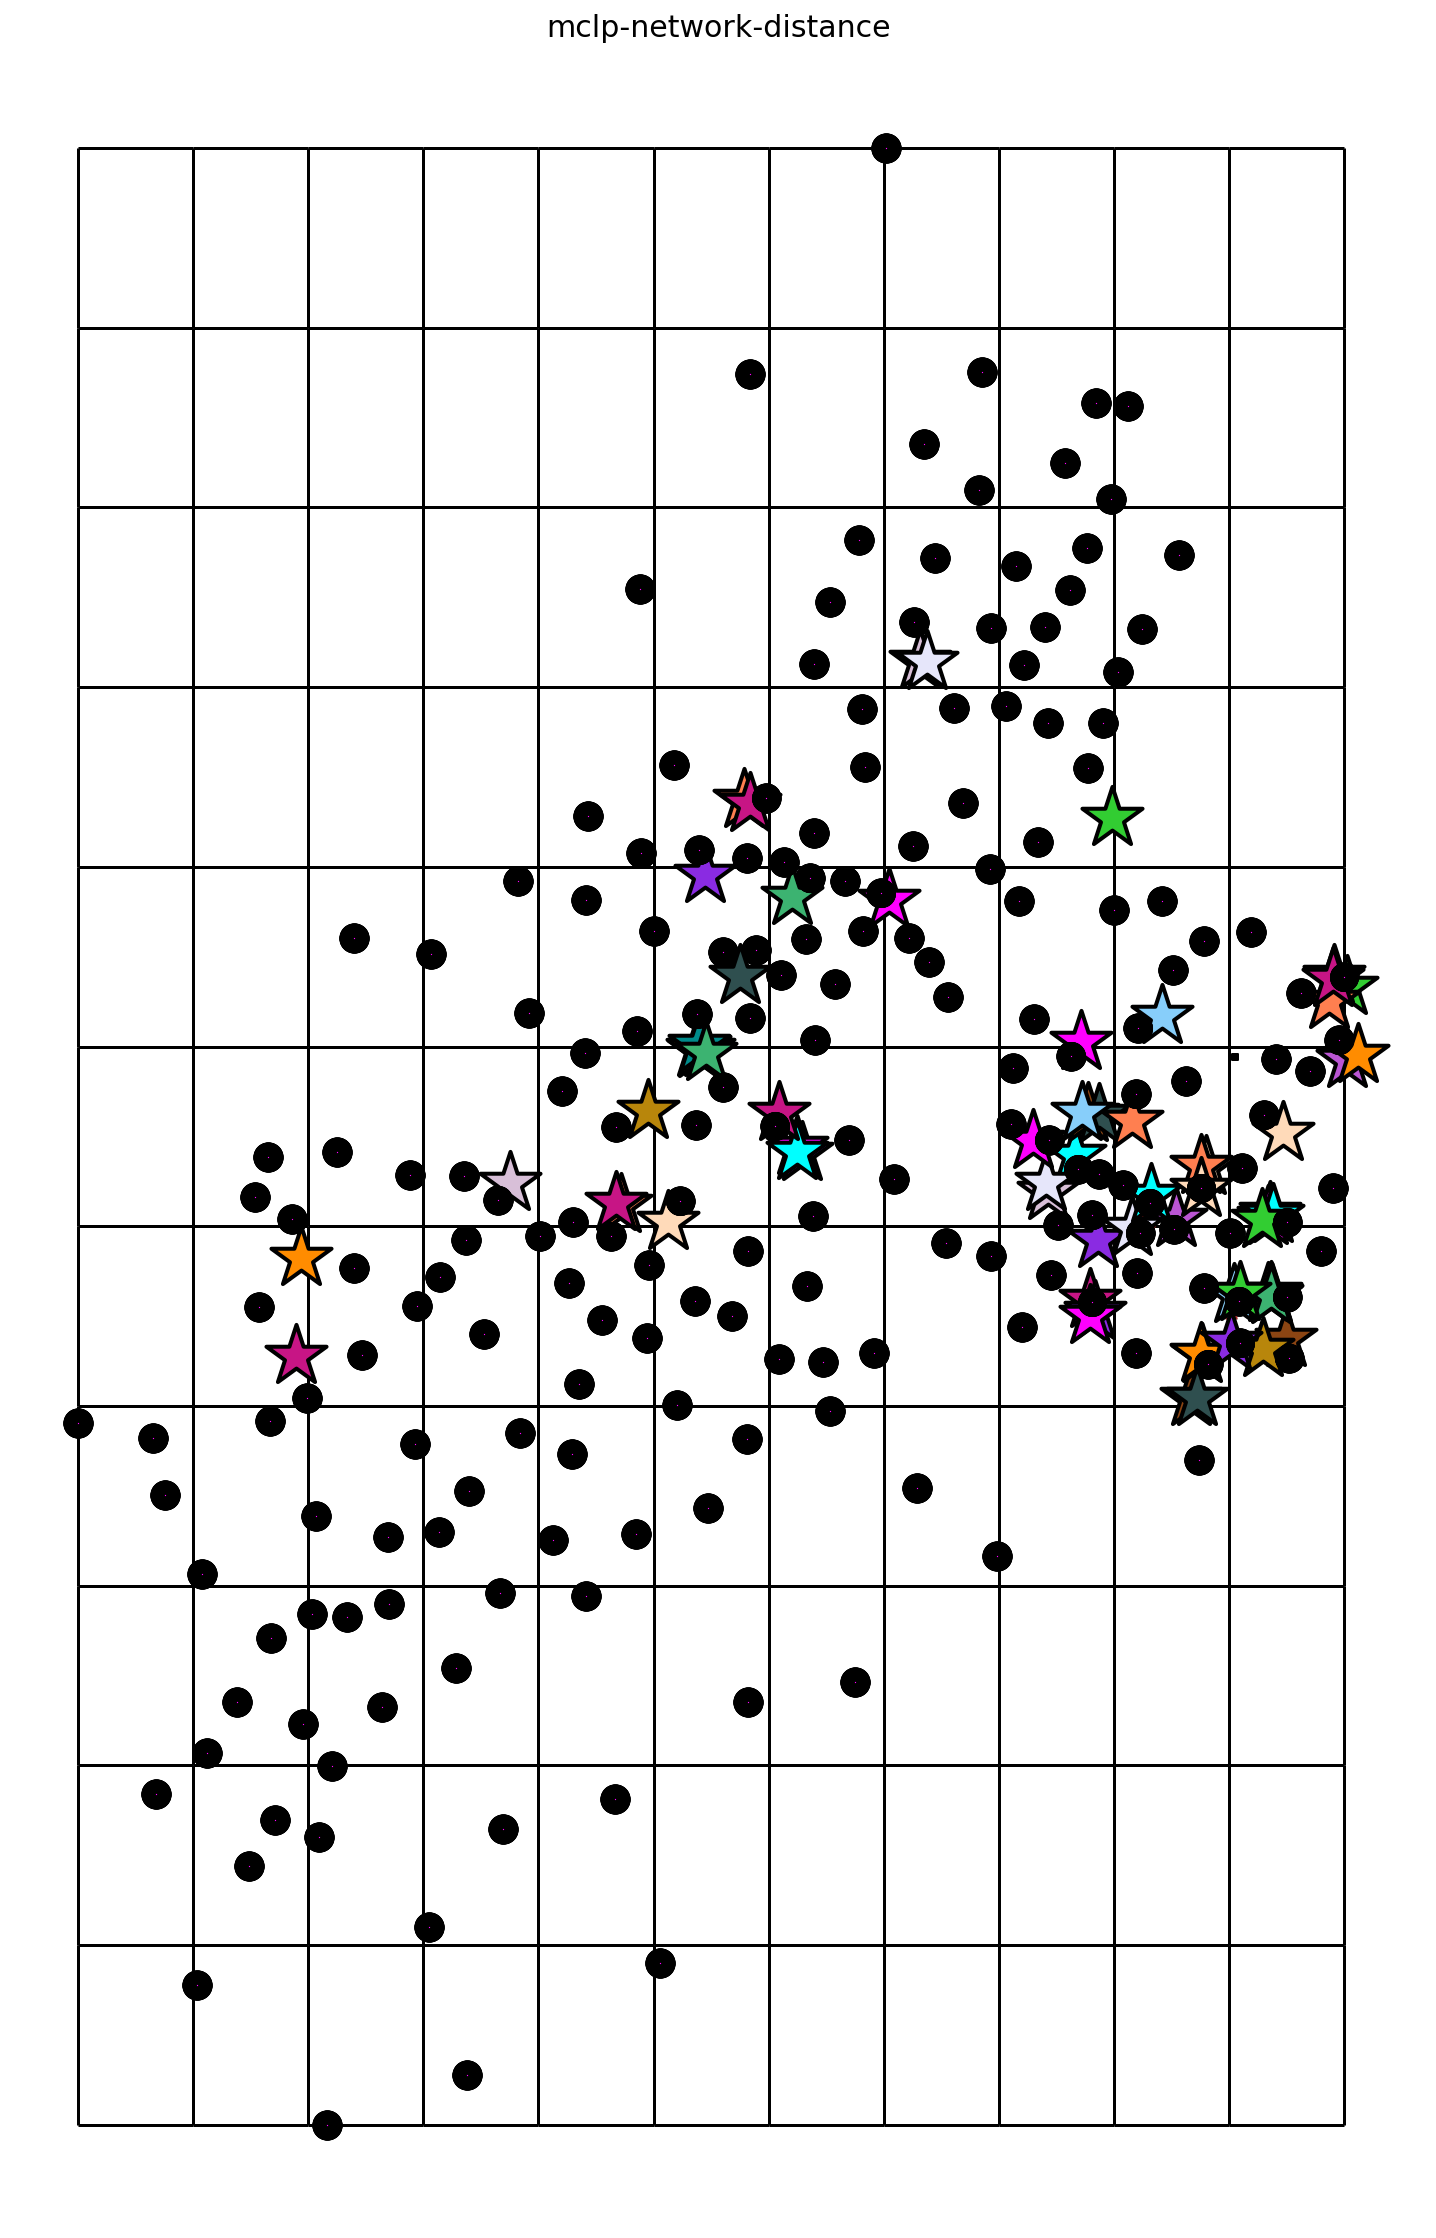

In [ ]:
# fig, axarr = plt.subplots(1,3, figsize=(20, 10))
# fig.subplots_adjust(wspace=-0.01)
# for i, m in enumerate([mclp_from_cm]):
#     plot_results(m, P_FACILITIES, facility_points, clis=client_points, ax=axarr[i])

import matplotlib.pyplot as plt

# Create a single figure and axis object
fig, ax = plt.subplots(figsize=(20, 20))  # Adjust the size as needed

# Plot the results on the single axis
plot_results(mclp_from_cm, P_FACILITIES, facility_points, clis=client_points, ax=ax)

# Display the plot
plt.show()
